# Image classification of Breast Ultra Sound Images

Here we experiment with deep learning algorithms - CNN


### Import packages

In [1]:
import os
import re
import random
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import RandomizedSearchCV
from utils import init_img_dict, get_file_dicts, filter_files, find_mask, print_ndarray_info
from utils import img_read, img_write, img_resize, img_flip, comp_fft, histogram_equalization
from utils import display_img, display_img_list_3, display_3_imgs, display_3_hist, resize_imgs, flip_imgs, append_img_data

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, confusion_matrix 
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier, KerasRegressor
# import talos
# from talos.utils import lr_normalizer

In [2]:
import os
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

import sys
import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adagrad

In [3]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/home/ec2-user/.conda/envs/jupyter/bin/python3.8
3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) 
[GCC 10.3.0]
sys.version_info(major=3, minor=8, micro=13, releaselevel='final', serial=0)


## Read image list (with dict object for each image) for the 2 classes (Benign and Malignant)
 - Read benign and malignant dataset into a list

In [5]:
img_res = 256

benign_img_dir = './Dataset_BUSI_with_GT/benign_256'
malignant_img_dir = './Dataset_BUSI_with_GT/malignant_256'

# Get a list of images in the images directory
benign_img_list_all = get_file_dicts(benign_img_dir)
num_benign_img = len(benign_img_list_all)
print(f"Number of images in benign dataset: {num_benign_img}")

malignant_img_list_all = get_file_dicts(malignant_img_dir)
num_malignant_img = len(malignant_img_list_all)
print(f"Number of images in malignant dataset: {num_malignant_img}")

Number of images in benign dataset: 437
Number of images in malignant dataset: 420


## Prepare data for classification
 - Assemble feature data (pixels) and target data (0 for benign and 1 for malignant)
 - Shuffle the data
 - Split data in to training and test (70-30) set
 - Scale the data (use Standard scaler)

In [25]:
def import_images(img_list, label):
    images = []
    masks = []
    labels = []
    for item in img_list:
        img = cv2.imread(item['file_name_fullpath'], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(item['file_masks'][0], cv2.IMREAD_GRAYSCALE)
        images.append(img)
        masks.append(mask)
        labels.append(label)
    return images, masks, labels

# normal_im, normal_mk, n_l = import_images(normal_img_list, 0)
benign_im, benign_mk, b_l = import_images(benign_img_list_all, 0)
malignant_im, malignant_mk, m_l = import_images(malignant_img_list_all, 1)

X = benign_im + malignant_im
L = b_l+m_l

x_resize=[]
img_size=256

for x in X:
    new_array = cv2.resize(x,(img_size,img_size))
    x_resize.append(new_array)
x_resize = np.array(x_resize)
x_resize = x_resize.reshape(x_resize.shape[0], x_resize.shape[1], x_resize.shape[2], 1)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x_resize,L, test_size=0.2, random_state= 7, stratify= L)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=7,  stratify= y_test) 

### CNN Model Set Up 

In [7]:
def create_model(opt = 'adam', learning_rate = .001):
# Create a model and trin
    model = tf.keras.Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(256, 256,1)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(2, activation='softmax'))
    if opt == 'adagrad':
        opt = Adagrad(lr=learning_rate)
    elif opt == 'adam':
        opt = Adam(lr=learning_rate)
    model.compile(optimizer = opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model 

#### Hyperparameter Tuning - Grid Search Set Up

We are running a Random grid search though the parameters below: batch size, optimizers, learning rate, and epochs. We decided to use a random grid search because studies have shown that it provides the same level of effectiveness as a regular gridsearch but it's less time consuming.

In [8]:
batch_size = [16, 32]
opt = ['adam', 'adagrad']
learning_rate = [.001, .01]
epochs = [10, 15, 20]
param_grid = dict(opt= opt, learning_rate = learning_rate, batch_size = batch_size,epochs = epochs)

In [ ]:
model = KerasClassifier(build_fn=create_model, learning_rate=0.0001, opt='adam', verbose=1)

n_iter_search = 10 # Number of parameter settings that are sampled.
grid = RandomizedSearchCV(estimator=model, cv =3, 
                                   param_distributions=param_grid,
                                   n_iter=n_iter_search, verbose = 10, n_jobs = -1)
grid_result = grid.fit(X_train, y_train)

In [11]:
def display_cv_results(search_results):
    print('Best score = {:.4f} using {}'.format(search_results.best_score_, search_results.best_params_))
    means = search_results.cv_results_['mean_test_score']
    stds = search_results.cv_results_['std_test_score']
    params = search_results.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print('mean test accuracy +/- std = {:.4f} +/- {:.4f} with: {}'.format(mean, stdev, param))  

As you can see in the output below of the grid search, the best score on the 3 fold cross validation came from an adagrad optimizer with a learning rate of .01, 15 epochs and a batch size of 16. 

In [12]:
display_cv_results(grid_result)

Best score = 0.8335 using {'opt': 'adagrad', 'learning_rate': 0.01, 'epochs': 15, 'batch_size': 16}
mean test accuracy +/- std = 0.6714 +/- 0.1073 with: {'opt': 'adagrad', 'learning_rate': 0.01, 'epochs': 10, 'batch_size': 32}
mean test accuracy +/- std = 0.5095 +/- 0.0010 with: {'opt': 'adam', 'learning_rate': 0.01, 'epochs': 20, 'batch_size': 32}
mean test accuracy +/- std = 0.8335 +/- 0.0192 with: {'opt': 'adagrad', 'learning_rate': 0.01, 'epochs': 15, 'batch_size': 16}
mean test accuracy +/- std = 0.7853 +/- 0.0543 with: {'opt': 'adam', 'learning_rate': 0.001, 'epochs': 20, 'batch_size': 32}
mean test accuracy +/- std = 0.7326 +/- 0.1058 with: {'opt': 'adagrad', 'learning_rate': 0.01, 'epochs': 20, 'batch_size': 32}
mean test accuracy +/- std = 0.5022 +/- 0.0093 with: {'opt': 'adam', 'learning_rate': 0.01, 'epochs': 20, 'batch_size': 16}
mean test accuracy +/- std = 0.7109 +/- 0.0468 with: {'opt': 'adagrad', 'learning_rate': 0.01, 'epochs': 15, 'batch_size': 32}
mean test accuracy 

In [27]:
# run the model with the results from hyperparam tuning 
model = create_model(learning_rate=0.01, opt='adagrad')

history = model.fit(x=X_train, y=np.array(y_train), validation_data=(X_val, np.array(y_val)), batch_size=16, epochs=15, verbose=10)
 

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15


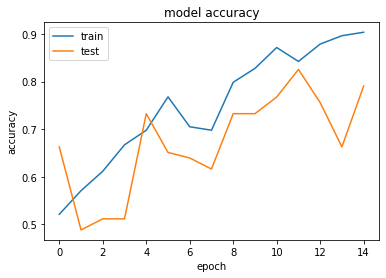

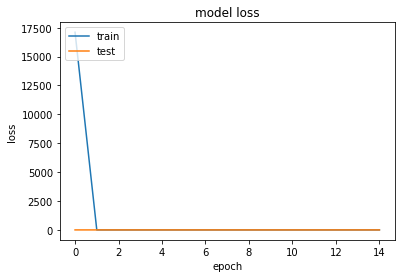

In [32]:
# Model quality analysis
# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**We have a testing accuracy of 78%. This is slightly lower than the accuracy on the valudation sets which was 82%.**

In [33]:
model.evaluate(np.array(X_test),np.array(y_test))

3/3 [==============================] - 1s 351ms/step - loss: 0.5581 - accuracy: 0.7791


[0.558110237121582, 0.7790697813034058]

3/3 [==============================] - 1s 353ms/step


Text(0.5, 62.15999999999998, 'Predicted')

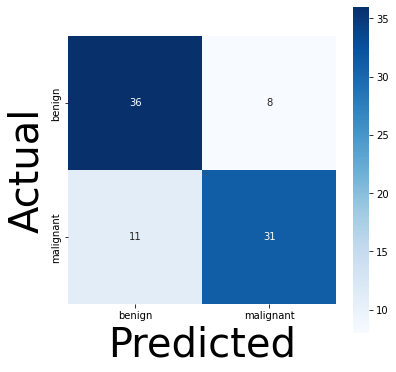

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predicted = [np.argmax(item) for item in model.predict(X_test)]

conf = confusion_matrix(y_test,predicted)
conf

info = [
    'benign'   ,  # 0
    'malignant',  # 1
]
plt.figure(figsize = (6,6))
ax = sns.heatmap(conf, cmap=plt.cm.Blues, annot=True, square=True, xticklabels = info, yticklabels = info)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

### Results Insights and Analysis

We can see from the confusion matrix above that there are is an fairly equal number of False Negatives and False Positives. But in general, the model was able to predict the tumors well. In this case, becase of the nature of the problem, we want as few False Negatives as possible because it would be detrimental to mark a module as benign when it's actual cancerous. That could lead to fatality in the patient. We also see that out model is nor overfitting and is able to generalize well to the test data set. Our testing accuracy isn't too high and our validation sets accuracy is what we wanted it to be. That also resulted in a good test accruacy for us since the model was able to generalize well to new data presented.

### Improvements 

I think the trianing process could be improved if we had a larger dataset and a more balanced data set. We were able to balance it by mirroing and slightly distorting images in the benign class, but that doesn't allow the model to generalize as well as it could if we had had pictures of new modules. There are so many nuances to pick up between the benign and malignant tumors that we need as many datapoints as possible to build a model that can pick up on all possible qualities of differentiators.

### Limitations 

It makes sense that there were less modules that we predicted as malignant but were actuallt benign because I'm assuming the classifier picked up on the fact that malignant modules have jagged edges where as benign ones don't, and it's pretty rare for a benign module to have jadded edges of that nature. Our training process can also be improved if we were able to run a gridsearch on more parameters with more permutations and combinations. Due to comute limitations and time constraints, we weren't able to run as massive of a gridsearch as we wanted to. 